First, we load some books from project Gutenberg into strings.

In [1]:
# Setup

# Characters are represented by 1-hot vectors of size 128
char_dim = 128

In [2]:
import numpy as np
import os
from collections import Counter
import unicodedata
import string
import gc
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import LSTM
from torch import optim

In [3]:
np.random.seed(seed=0)

# replaces special characters with their close equivalents in order to simplify the characters that appear
def clean_text(text):
    return str(unicodedata.normalize('NFD', text).encode('ascii', 'ignore')).replace('\\n', '\n')

gutenberg_dir = 'Gutenberg/txt/'
gutenberg_files = os.listdir(gutenberg_dir)
myfiles = np.random.choice(gutenberg_files, 5)
mystrings = []
counters = []
combined_counter = Counter()
for file in myfiles:
    print('reading file %s' % file)
    myfile = open(gutenberg_dir + file, 'r')
    file_text = clean_text(myfile.read())
    print('read %d characters' % len(file_text))
    mystrings += [file_text]
    myfile.close()
    counter = Counter(file_text)
    counters += [counter]
    combined_counter += counter

print(combined_counter)

for key in combined_counter.keys():
    if ord(key) >= 128:
        print('invalid character value found: %s has numeric value %d', key, ord(key))

reading file Charlotte Mary Yonge___The Chaplet of Pearls.txt
read 1024073 characters
reading file Lyman Frank Baum___A Kidnapped Santa Claus.txt
read 20879 characters
reading file Edgar Allan Poe___The Fall of the House of Usher.txt
read 42717 characters
reading file Ambrose Bierce___Shapes of Clay.txt
read 276326 characters
reading file Louisa May Alcott___Rose in Bloom.txt
read 508189 characters
Counter({' ': 319728, 'e': 182439, 't': 120095, 'a': 110999, 'o': 104990, 'n': 95020, 'h': 91507, 'i': 87606, 's': 87355, 'r': 83463, 'd': 65156, 'l': 60010, 'u': 41981, '\n': 39592, 'm': 32782, 'c': 31379, 'w': 31077, 'f': 30514, 'g': 29189, ',': 28357, 'y': 27915, 'p': 21638, 'b': 20837, 'v': 13233, '.': 12169, "'": 11077, '\\': 11067, 'k': 10401, 'I': 6870, '-': 5413, '"': 4789, 'T': 4424, 'A': 4268, 'S': 2881, 'M': 2743, 'H': 2471, 'E': 2468, 'B': 2466, ';': 2367, '!': 2207, 'C': 2022, 'R': 1993, 'P': 1955, 'N': 1942, 'x': 1796, 'W': 1784, 'O': 1635, '?': 1530, 'L': 1468, 'D': 1402, 'q':

Train an LSTM on this data

In [4]:
# converts a list of N strings of length T into a numpy array of 1-hot vectors
# input size: (N, T)
# output size: (T, N, 128)
i128 = np.eye(128)
def char_to_ix(texts):
    ords = np.array([[ord(char) for char in text] for text in texts], dtype=int)
    return i128[ords].transpose((1, 0, 2))

# converts a list of N strings of length T into a numpy array of length (T, N)
def char_to_array(texts):
    ords = np.array([[ord(char) for char in text] for text in texts], dtype=int)
    return ords.transpose((1, 0))

#data = char_to_ix(mystrings[0])

In [5]:
class MyLSTM(nn.Module):
    def __init__(self, hidden_dim, num_stacks):
        super(MyLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(char_dim, hidden_dim, num_layers=num_stacks)
        
        # The linear layer that maps from hidden state space to character space
        self.hidden2char = nn.Linear(hidden_dim, char_dim)
        self.init_hidden_zeros(1)
    
    def init_hidden_zeros(self, minibatch_size):
        self.init_hidden(torch.zeros((self.lstm.num_layers, minibatch_size, self.hidden_dim)), torch.zeros((self.lstm.num_layers, minibatch_size, self.hidden_dim)))
    
    def init_hidden(self, h, c):
        self.hidden = (h, c)

    def forward(self, text):
        # text should be of size (T, N, char_dim)
        # returns character scores of size (T, N, char_dim)
        
        hs, self.hidden = self.lstm(text, self.hidden)
        char_space = self.hidden2char(hs)
        return char_space

In [6]:
def model_loss(model, loss_func, data_ix, data_array):
    model.lstm.eval()
    model.init_hidden_zeros(data_ix.shape[1])
    sequence_in = data_ix[:-1, :, :]
    minibatch_size = data_ix.shape[1]
    loss = 0
    with torch.no_grad():
        for i, char_in in enumerate(sequence_in):
            char_scores = model(char_in.view(1, minibatch_size, -1))
            loss += loss_func(char_scores.view(-1, char_dim), data_array[i+1,:])
    model.lstm.train()
    return loss / len(sequence_in)

In [7]:
# free some memory if possible
train_data = None
val_data = None
test_data = None
val_data_ix = None
val_data_array = None
test_data_ix = None
test_data_array = None
gc.collect()

train_data = ''
val_data = ''
test_data = ''

for string in mystrings:
    train_data += string[:len(string) * 8 // 10]
    val_data += string[len(string) * 8 // 10:len(string) * 9 // 10]
    test_data += string[len(string) * 9 // 10:]

train_data_ix = torch.tensor(char_to_ix([train_data]), dtype=torch.float)
train_data_array = torch.tensor(char_to_array([train_data])).view(-1, 1)

val_data_ix = torch.tensor(char_to_ix([val_data]), dtype=torch.float)
val_data_array = torch.tensor(char_to_array([val_data])).view(-1, 1)

test_data_ix = torch.tensor(char_to_ix([test_data]), dtype=torch.float)
test_data_array = torch.tensor(char_to_array([test_data])).view(-1, 1)

print(len(train_data))
print(len(val_data))
print(len(test_data))


#train_data = mystrings[0][:90000]
#
## data_ix is of shape (T, N, char_dim) while data_array is of shape (T, N)
#train_data_ix = torch.tensor(char_to_ix([train_data]), dtype=torch.float)
#train_data_array = torch.tensor(char_to_array([train_data])).view(-1, 1)
#
#val_data = mystrings[0][-100000:-50000]
#
## data_ix is of shape (T, N, char_dim) while data_array is of shape (T, N)
#val_data_ix = torch.tensor(char_to_ix([val_data]), dtype=torch.float)
#val_data_array = torch.tensor(char_to_array([val_data])).view(-1, 1)
#
#test_data = mystrings[0][-50000:]
#
## data_ix is of shape (T, N, char_dim) while data_array is of shape (T, N)
#test_data_ix = torch.tensor(char_to_ix([test_data]), dtype=torch.float)
#test_data_array = torch.tensor(char_to_array([test_data])).view(-1, 1)

1497745
187219
187220


In [ ]:
model = MyLSTM(64, 3)
model.lstm.dropout=0.2
#model.load_state_dict(torch.load('model_checkpoint_h100_3layer_epoch9'))
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())
seq_len = 1000
minibatch_size = 8

train_losses_dropout = []
val_losses_dropout = []

for epoch in range(30):
    print('on epoch %d' % epoch)
    for i in range(len(train_data) // (seq_len * minibatch_size)):
        print('\r\ton iteration %d / %d' % (i, len(train_data) // (seq_len * minibatch_size)), end='')
        model.zero_grad()
        model.init_hidden_zeros(minibatch_size)
        
        sequence_in = torch.zeros((seq_len - 1, minibatch_size, char_dim))
        sequence_out = torch.zeros((seq_len - 1, minibatch_size), dtype=torch.long)
        for b in range(minibatch_size):
            sequence_in[:,b,:] = train_data_ix[seq_len * (i * minibatch_size + b)
                                               :
                                               seq_len * (i * minibatch_size + b + 1) - 1
                                               ,0,:
                                              ]
            
            sequence_out[:,b] =  train_data_array[seq_len * (i * minibatch_size + b) + 1
                                                  :
                                                  seq_len * (i * minibatch_size + b + 1) 
                                                  ,0
                                                 ]
        #sequence_in = train_data_ix[seq_len * i:seq_len * (i + 1) - 1, :, :]
        #sequence_out = train_data_array[seq_len * i + 1:seq_len * (i + 1), :]
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.view(-1, char_dim), sequence_out.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix[10000:20000,:,:], train_data_array[10000:20000,:])
    val_loss = model_loss(model, loss_func, val_data_ix[:10000,:,:], val_data_array[:10000,:])
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_dropout += [train_loss]
    val_losses_dropout += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_2_h64_3layer_dropout_epoch' + str(epoch))

train_loss = model_loss(model, loss_func, train_data_ix[:100000,:,:], train_data_array[:100000,:])
val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
print('\ttraining loss = %f' % train_loss)
print('\tvalidation loss = %f' % val_loss)
train_losses_dropout += [train_loss]
val_losses_dropout += [val_loss]

on epoch 0
	on iteration 186 / 187
	training loss = 2.759114
	validation loss = 2.738409
on epoch 1
	on iteration 186 / 187
	training loss = 2.401613
	validation loss = 2.377035
on epoch 2
	on iteration 186 / 187
	training loss = 2.215128
	validation loss = 2.183825
on epoch 3
	on iteration 186 / 187
	training loss = 2.061440
	validation loss = 2.012751
on epoch 4
	on iteration 186 / 187
	training loss = 1.942938
	validation loss = 1.905285
on epoch 5
	on iteration 186 / 187
	training loss = 1.866682
	validation loss = 1.825751
on epoch 6
	on iteration 186 / 187
	training loss = 1.821900
	validation loss = 1.778414
on epoch 7
	on iteration 186 / 187
	training loss = 1.775339
	validation loss = 1.740070
on epoch 8
	on iteration 186 / 187
	training loss = 1.751027
	validation loss = 1.711234
on epoch 9
	on iteration 186 / 187
	training loss = 1.710356
	validation loss = 1.671327
on epoch 10
	on iteration 186 / 187
	training loss = 1.692259
	validation loss = 1.656205
on epoch 11
	on iter

In [141]:
model = MyLSTM(64, 3)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
seq_len = 1000
minibatch_size = 16

train_losses_h64_l3 = []
val_losses_h64_l3 = []

for epoch in range(100):
    print('on epoch %d' % epoch)
    for i in range(len(train_data) // (seq_len * minibatch_size)):
        print('\r\ton iteration %d / %d' % (i, len(train_data) // (seq_len * minibatch_size)), end='')
        model.zero_grad()
        model.init_hidden_zeros(minibatch_size)
        
        sequence_in = torch.zeros((seq_len - 1, minibatch_size, char_dim))
        sequence_out = torch.zeros((seq_len - 1, minibatch_size), dtype=torch.long)
        for b in range(minibatch_size):
            sequence_in[:,b,:] = train_data_ix[seq_len * (i * minibatch_size + b)
                                               :
                                               seq_len * (i * minibatch_size + b + 1) - 1
                                               ,0,:
                                              ]
            
            sequence_out[:,b] =  train_data_array[seq_len * (i * minibatch_size + b) + 1
                                                  :
                                                  seq_len * (i * minibatch_size + b + 1) 
                                                  ,0
                                                 ]
        #sequence_in = train_data_ix[seq_len * i:seq_len * (i + 1) - 1, :, :]
        #sequence_out = train_data_array[seq_len * i + 1:seq_len * (i + 1), :]
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.view(-1, char_dim), sequence_out.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix[10000:20000,:,:], train_data_array[10000:20000,:])
    val_loss = model_loss(model, loss_func, val_data_ix[:10000,:,:], val_data_array[:10000,:])
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_h64_l3 += [train_loss]
    val_losses_h64_l3 += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_2_h64_3layer_epoch' + str(epoch))

train_loss = model_loss(model, loss_func, train_data_ix[:100000,:,:], train_data_array[:100000,:])
val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
print('training loss = %f' % train_loss)
print('validation loss = %f' % val_loss)
train_losses_h64_l3 += [train_loss]
val_losses_h64_l3 += [val_loss]

#################################

model = MyLSTM(64, 2)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
seq_len = 1000
minibatch_size = 16

train_losses_h64_l2 = []
val_losses_h64_l2 = []

for epoch in range(100):
    print('on epoch %d' % epoch)
    for i in range(len(train_data) // (seq_len * minibatch_size)):
        print('\r\ton iteration %d / %d' % (i, len(train_data) // (seq_len * minibatch_size)), end='')
        model.zero_grad()
        model.init_hidden_zeros(minibatch_size)
        
        sequence_in = torch.zeros((seq_len - 1, minibatch_size, char_dim))
        sequence_out = torch.zeros((seq_len - 1, minibatch_size), dtype=torch.long)
        for b in range(minibatch_size):
            sequence_in[:,b,:] = train_data_ix[seq_len * (i * minibatch_size + b)
                                               :
                                               seq_len * (i * minibatch_size + b + 1) - 1
                                               ,0,:
                                              ]
            
            sequence_out[:,b] =  train_data_array[seq_len * (i * minibatch_size + b) + 1
                                                  :
                                                  seq_len * (i * minibatch_size + b + 1) 
                                                  ,0
                                                 ]
        #sequence_in = train_data_ix[seq_len * i:seq_len * (i + 1) - 1, :, :]
        #sequence_out = train_data_array[seq_len * i + 1:seq_len * (i + 1), :]
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.view(-1, char_dim), sequence_out.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix[10000:20000,:,:], train_data_array[10000:20000,:])
    val_loss = model_loss(model, loss_func, val_data_ix[:10000,:,:], val_data_array[:10000,:])
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_h64_l2 += [train_loss]
    val_losses_h64_l2 += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_2_h64_2layer_epoch' + str(epoch))

train_loss = model_loss(model, loss_func, train_data_ix[:100000,:,:], train_data_array[:100000,:])
val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
print('training loss = %f' % train_loss)
print('validation loss = %f' % val_loss)
train_losses_h64_l2 += [train_loss]
val_losses_h64_l2 += [val_loss]

on epoch 0
	on iteration 102 / 103
	training loss = 2.877763
	validation loss = 2.956334
on epoch 1
	on iteration 102 / 103
	training loss = 2.323029
	validation loss = 2.362127
on epoch 2
	on iteration 102 / 103
	training loss = 2.082082
	validation loss = 2.160674
on epoch 3
	on iteration 102 / 103
	training loss = 1.961999
	validation loss = 2.034866
on epoch 4
	on iteration 102 / 103
	training loss = 1.888387
	validation loss = 1.970176
on epoch 5
	on iteration 102 / 103
	training loss = 1.802883
	validation loss = 1.874738
on epoch 6
	on iteration 102 / 103
	training loss = 1.755734
	validation loss = 1.831897
on epoch 7
	on iteration 102 / 103
	training loss = 1.709172
	validation loss = 1.782555
on epoch 8
	on iteration 102 / 103
	training loss = 1.666104
	validation loss = 1.739648
on epoch 9
	on iteration 102 / 103
	training loss = 1.644136
	validation loss = 1.724389
on epoch 10
	on iteration 102 / 103
	training loss = 1.611974
	validation loss = 1.688711
on epoch 11
	on iter

	on iteration 102 / 103
	training loss = 1.395613
	validation loss = 1.529234
on epoch 92
	on iteration 102 / 103
	training loss = 1.373100
	validation loss = 1.510688
on epoch 93
	on iteration 102 / 103
	training loss = 1.376405
	validation loss = 1.518935
on epoch 94
	on iteration 102 / 103
	training loss = 1.385087
	validation loss = 1.526511
on epoch 95
	on iteration 102 / 103
	training loss = 1.385967
	validation loss = 1.528432
on epoch 96
	on iteration 102 / 103
	training loss = 1.374249
	validation loss = 1.511094
on epoch 97
	on iteration 102 / 103
	training loss = 1.385301
	validation loss = 1.524568
on epoch 98
	on iteration 102 / 103
	training loss = 1.382267
	validation loss = 1.518091
on epoch 99
	on iteration 102 / 103
	training loss = 1.395571
	validation loss = 1.532990
training loss = 1.519025
validation loss = 1.607826
on epoch 0
	on iteration 102 / 103
	training loss = nan
	validation loss = nan
on epoch 1
	on iteration 102 / 103
	training loss = nan
	validation los

KeyboardInterrupt: 

minimum validation loss wsa 1.510688 at epoch 92


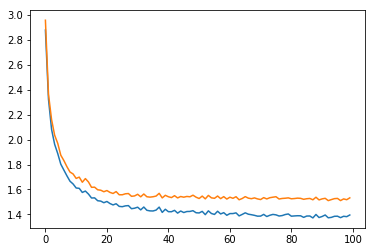

In [148]:
x = np.arange(100)
plt.plot(x, train_losses_h64_l3[:-1], label='training loss')
plt.plot(x, val_losses_h64_l3[:-1], label='validation loss')
print('minimum validation loss wsa %f at epoch %d' % (np.min(val_losses_h64_l3), np.argmin(val_losses_h64_l3)))

In [155]:
best_model = MyLSTM(64, 3)
best_model.load_state_dict(torch.load('model_checkpoint_2_h64_3layer_epoch50'))

In [157]:
softmax = torch.nn.Softmax()
chars = range(128)

def sample_char(char_scores, temp):
    char_scores = softmax(char_scores / temp)
    char = np.random.choice(chars, p=char_scores.detach().numpy())
    while not chr(char) in string.printable:
        char = np.random.choice(chars, p=char_scores.detach().numpy())
    return char

def sample(model, first_char, init_hidden, T, temp):
    result = first_char
    cur_char = ord(first_char)
    for t in range(T):
        one_hot_char = torch.tensor(i128[cur_char], dtype=torch.float).view(1, 1, -1)
        char_scores = model(one_hot_char)
        cur_char = sample_char(char_scores.view(-1), temp)
        result += chr(cur_char)
    return result.replace('\\n', '\n') # I messed up the encoding of newliens

print(sample(best_model, 'T', torch.zeros((1, 1, model.hidden_dim)), 500, 0.5))

/home/alex/bin/anaconda3/envs/cs682/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


TEr or a Portugueses and selding in the Proper Word, and the _Devil_ to act the Disguise, and he think his Spirit is the _Devil_ has been explain in all the Appearance and proverb to enquire up as him to make a Committen of _Devils_, who would be known a Command, the _Devil_
of the Performing to the World.

The Story of the Discomet as a great Devil was to our old _Devil_, that they for the World but what he had not to be according to it as to come out of the fair _Devil_ in the Side, and the 
